# Simple TokaMaker static equilibrium example for NextStep Fusion NT design

In [1]:
import os
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.interpolate import CubicSpline
plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['lines.linewidth']=2
plt.rcParams['lines.markeredgewidth']=2
%matplotlib inline
%config InlineBackend.figure_format = "retina"

## Load TokaMaker library

To load the TokaMaker python module we need to tell python where to the module is located. This can be done either through the `PYTHONPATH` environment variable or using within a script using `sys.path.append()` as below, where we look for the environement variable `OFT_ROOTPATH` to provide the path to where the OpenFUSIONToolkit is installed (`/Applications/OFT` on macOS).

In [2]:
tokamaker_python_path = os.getenv('OFT_ROOTPATH')
if tokamaker_python_path is not None:
    sys.path.append(os.path.join(tokamaker_python_path,'python'))
from OpenFUSIONToolkit.TokaMaker import TokaMaker, load_gs_mesh, create_isoflux

## Setup solver

### Initialize TokaMaker object
First we create a TokaMaker instance to use for equilibrium calculations. Note at present only a single instance can be used per python kernel, so this command should only be called **once** in a given Jupyter notebook or python script. In the future this restriction may be relaxed.

In [3]:
mygs = TokaMaker()

#----------------------------------------------
OpenFUSIONToolkit Initialized
Development branch:   main
Revision id:          11ca7a7
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    2
Fortran input file    = oftpyin                                                                         
XML input file        = none                                                                            
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------



### Load mesh into TokaMaker
Now we load the mesh generated in the previous script using `load_gs_mesh` and `setup_mesh`. Then we use `setup_regions` to define the different region types. Finally, we call `setup` to setup the required solver objects. During this call we can specify the desired element order (min=2, max=4) and the toroidal field through F0 = B0*R0, where B0 is the toroidal field at a reference location R0. We also increase the maximum number of Picard iterations in the equilibrium solve to 80 from the default of 40.

In [4]:
mesh_pts,mesh_lc,mesh_reg,coil_dict,cond_dict = load_gs_mesh('NextStep_NT_mesh.h5')
mygs.setup_mesh(mesh_pts, mesh_lc, mesh_reg)
mygs.setup_regions(cond_dict=cond_dict)
mygs.settings.maxits = 80
mygs.setup(order=2, F0=0.8*3)


**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  3.917E+00
    # of points  =    3710
    # of edges   =   11023
    # of cells   =    7314
    # of boundary points =     104
    # of boundary edges  =     104
    # of boundary cells  =     104
  Resolution statistics:
    hmin =  9.267E-03
    hrms =  3.715E-02
    hmax =  1.096E-01
  Surface grounded at vertex     403


**** Creating Lagrange FE space
  Order  =    2
  Minlev =   -1

 Computing flux BC matrix 
 Inverting real matrix
   Time =    8.6799999999999996E-004


### Define a vertical stability coil
Like many elongated equilibria, the equilibrium we seek to compute below is vertically unstable. So we define a pair of coils, and corresponding polarities, that will be used to control the vertical position in the equilibrium solve. In this case we use EF3 for this purpose.

In [5]:
vsc_signs = np.zeros((mygs.ncoils,), dtype=np.float64)
vsc_signs[[coil_dict['EF3U']['coil_id'], coil_dict['EF3L']['coil_id']]] = [1.0,-1.0]
mygs.set_coil_vsc(vsc_signs)

### Define hard limits on coil currents
Hard limits on coil currents can be set using `set_coil_bounds`, which are then used in the shape fitting below.

In [6]:
coil_bounds = np.zeros((mygs.ncoils+1,2), dtype=np.float64)
coil_bounds[:,0] = -5.E6; coil_bounds[:,1] = 5.E6
mygs.set_coil_bounds(coil_bounds)

## Compute inverse equilibrium

### Define global quantities and targets
For the inverse case we define a target for the plasma current and the ratio the F*F' and P' contributions to the plasma current, which is approximately related to $\beta_p$ as Ip_ratio = $1/\beta_p - 1$.

**Note:** These constraints can be considered "hard" constraints, where they will be matched to good tolerance as long as the calculation converges.

In [7]:
Ip_target = 1.E6
mygs.set_targets(Ip=Ip_target,Ip_ratio=1.0)

### Define shape targets
In order to constrain the shape of the plasma we can utilize two types of constraints:
 1. `isoflux` points, which are points we want to lie on the same flux surface (eg. the LCFS)
 2. `saddle` points, where we want the poloidal magnetic field to vanish (eg. X-points). While one can also use this constraint to enforce a magnetic axis location, instead `set_targets` should be used with arguments `R0` and `V0`.

**Note:** These constraints can be considered "soft" constraints, where the calculation attempts to minimize error in satisfying these constraints subject to other constraints and regularization.

Here we define a handful of isoflux points that we want to lie on the LCFS of the target equilibrium. Additionally, we define two X-points and set them as saddle constraints as well as add them to the list of isoflux points.

In [8]:
boundary = create_isoflux(4,0.8,0.0,0.2588,1.7,-0.5)
x_points = np.zeros((2,2))
x_points[0,:] = boundary[np.argmin(boundary[:,1]),:]
x_points[1,:] = boundary[np.argmax(boundary[:,1]),:]

x_weights = 5*np.ones(2)
mygs.set_saddles(x_points, x_weights)

mygs.set_isoflux(boundary, 10.0*np.ones(4))

### Define coil regularization matrix
In general, for a given coil set a given plasma shape cannot be exactly reproduced, which generally yields large amplitude coil currents if no constraint on the coil currents is applied. As a result, it is useful to include regularization terms for the coils to balance minimization of the shape error with the amplitude of current in the free coils. In TokaMaker these regularization terms have the general form of a vector of targets (often zero), a regularization matrix that maps the coil currents to the targets, and a vector of weights that can be used to control the relative impact of each term in the minimization.

Here we define three types of regularization targets:
 1. Targets that act to penalize up-down assymetry in U/L coil pairs
 2. Targets the act to penalize the amplitude of current in each coil

In the later case this regularization acts to penalize the amplitude of current in each coil, acting to balance coil current with error in the shape targets. Additionally, this target is also used to "disable" several coils by setting the weight on their targets high to strongly penalize non-zero current.

In [9]:
coil_regmat = np.zeros((mygs.ncoils+1,mygs.ncoils+1), dtype=np.float64)
coil_reg_weights = np.zeros((mygs.ncoils+1,), dtype=np.float64)
disable_list = ('CS')
for name, coil in coil_dict.items():
    if name.find('U') >= 0: # Set regularization to enforce up-down symmetry
        coil_regmat[coil['coil_id'],coil['coil_id']] = 1.0
        coil_regmat[coil['coil_id'],coil_dict[name.replace('U','L')]['coil_id']] = -1.0
        coil_reg_weights[coil['coil_id']] = 1.E-1
    else: # Normal regularization
        coil_regmat[coil['coil_id'],coil['coil_id']] = 1.0
        if name[:3] in disable_list:
            coil_reg_weights[coil['coil_id']] = 1.E4
        else:
            coil_reg_weights[coil['coil_id']] = 1.E-3
# Terms for VSC coil
coil_regmat[-1,-1] = 1.0
coil_reg_weights[-1] = 1.E-4

mygs.set_coil_reg(coil_regmat,reg_weights=coil_reg_weights)

### Define flux functions
Although TokaMaker has a "default" profile for the F\*F' and P' terms this should almost never be used and one should instead choose an appropriate flux function for their application. In this case we use a simple power-like profile. Within TokaMaker this profile is represented as a piecewise linear function, which can be set up using the dictionary approach shown below.

*More tools to aide in setting these profiles are coming soon*. For example, we already have a working H-mode pedestal profile with self-consistent bootstrap that we will merge in shortly.

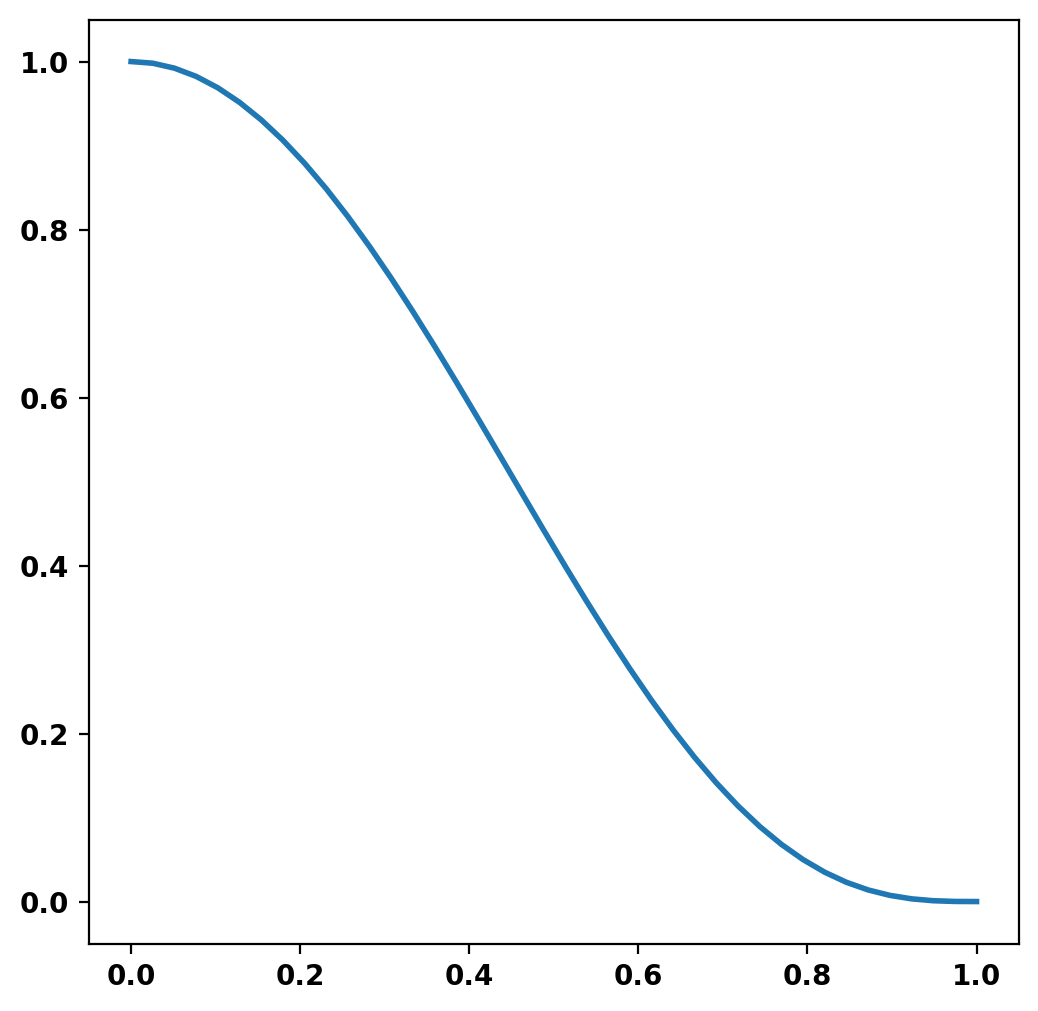

In [10]:
psi_sample = np.linspace(0.0,1.0,40)
alpha = 2.0
beta = 3.0
ffp_prof = {
    'type': 'linterp',
    'x': psi_sample,
    'y': np.power(1.0-np.power(psi_sample,alpha),beta)
}
pp_prof = {
    'type': 'linterp',
    'x': psi_sample,
    'y': np.power(1.0-np.power(psi_sample,alpha),beta)
}
plt.plot(ffp_prof['x'],ffp_prof['y'])
mygs.set_profiles(ffp_prof=ffp_prof,pp_prof=pp_prof)

### Initialize equilibrium calculation
We can now compute a free-boundary equilibrium using these constraints. Note that before running a calculation for the first time we must initialize the flux function $\psi$, which can be done using `init_psi`. This subroutine initializes the flux using the specified Ip_target from above, which is evenly distributed over the entire plasma region or only with a boundary defined using a center point (R,Z), minor radius (a), and elongation and triangularity. Coil currents are also initialized at this point using the constraints above and this uniform plasma current initialization. 

We plot the solution and coil currents after initialization but _before_ the Grad-Shafranov solve for reference.


Coil Currents [MA-Turns]:
  CS:              0.00
  EF0U:           -0.21
  EF1U:           -0.54
  EF2U:            0.76
  EF3U:           -0.72
  EF0L:           -0.21
  EF1L:           -0.54
  EF2L:            0.76
  EF3L:           -0.72


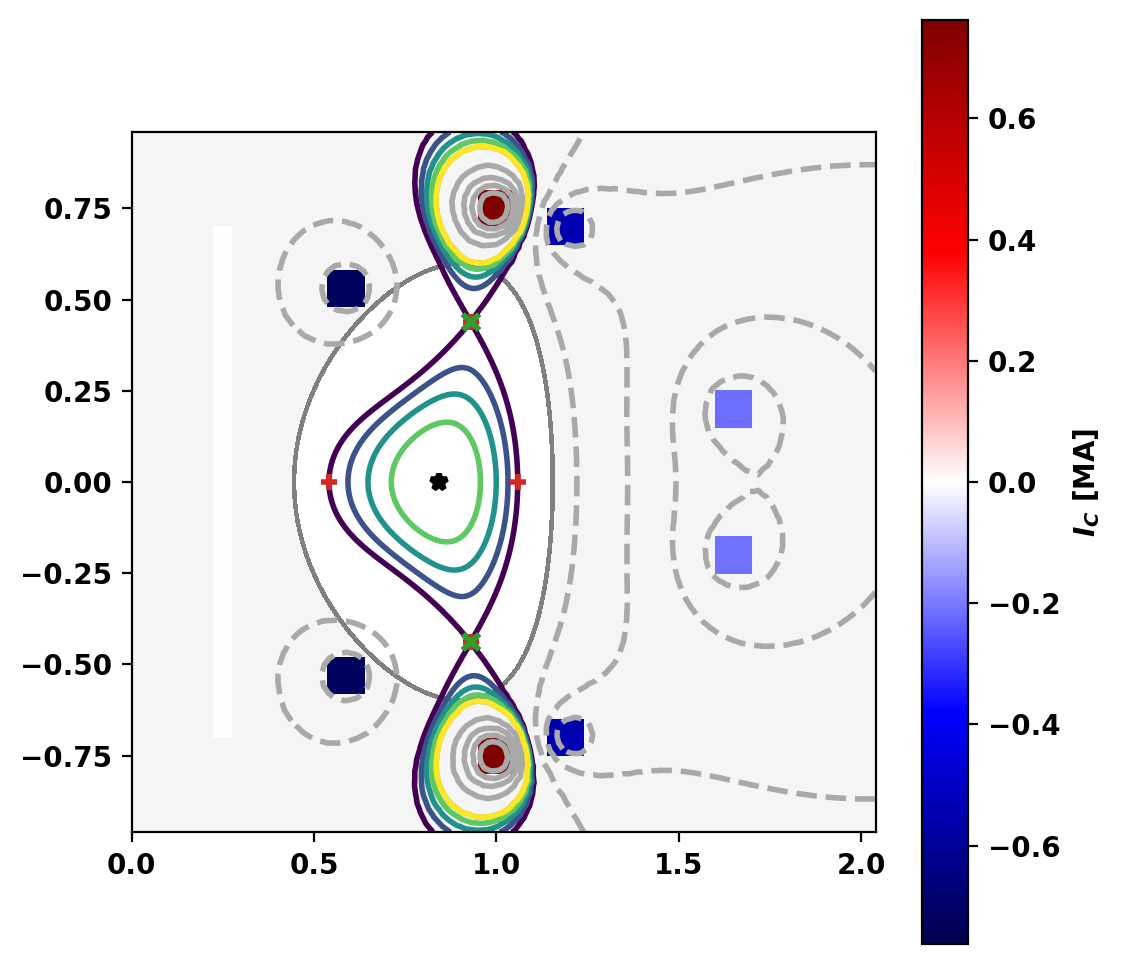

In [11]:
mygs.init_psi(0.68,0,0.2, 1.8,0.3)
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_scale=1.E-6,coil_clabel=r'$I_C$ [MA]',coil_symmap=True,limiter_color=None)
mygs.plot_psi(fig,ax,plasma_nlevels=5,vacuum_nlevels=5)
mygs.plot_constraints(fig, ax)
# Print initial coil currents
print()
print("Coil Currents [MA-Turns]:")
coil_currents, _ = mygs.get_coil_currents()
for key in coil_dict:
    i = coil_dict[key]['coil_id']
    print('  {0:10} {1:10.2F}'.format(key+":",coil_currents[i]/1.E6))

`solve` is then called to compute a self-consitent Grad-Shafranov equilibrium. If the result variable (`err_flag`) is zero then the solution has converged to the desired tolerance ($10^{-6}$ by default).

In [12]:
err_flag = mygs.solve()

Starting non-linear GS solver
     1  8.9771E+00  6.4579E+00  7.3623E-02  8.4488E-01 -1.1098E-04  6.5995E+02
     2  1.0004E+01  7.2675E+00  1.9788E-02  8.4390E-01 -8.1288E-05  4.4382E+02
     3  1.0329E+01  7.5397E+00  5.2833E-03  8.4306E-01 -5.8710E-05  3.3488E+02
     4  1.0469E+01  7.6632E+00  1.6421E-03  8.4245E-01 -4.2337E-05  2.6378E+02
     5  1.0533E+01  7.7230E+00  6.3094E-04  8.4203E-01 -3.0152E-05  2.1050E+02
     6  1.0563E+01  7.7526E+00  2.9139E-04  8.4177E-01 -2.1014E-05  1.7058E+02
     7  1.0577E+01  7.7674E+00  1.5054E-04  8.4161E-01 -1.4071E-05  1.3966E+02
     8  1.0583E+01  7.7748E+00  8.2481E-05  8.4150E-01 -8.7405E-06  1.1554E+02
     9  1.0586E+01  7.7785E+00  4.6717E-05  8.4144E-01 -4.6487E-06  9.6797E+01
    10  1.0588E+01  7.7804E+00  2.7033E-05  8.4141E-01 -1.4992E-06  8.2174E+01
    11  1.0588E+01  7.7814E+00  1.5885E-05  8.4139E-01  9.2797E-07  7.0769E+01
    12  1.0589E+01  7.7819E+00  9.4465E-06  8.4137E-01  2.8016E-06  6.1886E+01
    13  1.0589E+01  7.

### Print equilibrium information and coil currents
Basic parameters can be displayed using the `print_info` method. For access to these quantities as variables instead the `get_stats` can be used.

The final coil currents can also be retrieved using the `get_coil_currents` method, which are all within the approximate coil limits imposed above.

Equilibrium Statistics:
  Topology                =   Diverted
  Toroidal Current [A]    =    1.0000E+06
  Current Centroid [m]    =    0.829  0.000
  Magnetic Axis [m]       =    0.841  0.000
  Elongation              =    1.655 (U:  1.593, L:  1.716)
  Triangularity           =   -0.455 (U: -0.408, L: -0.501)
  Plasma Volume [m^3]     =    1.618
  q_0, q_95               =    0.582  2.169
  Peak Pressure [Pa]      =    4.2928E+05
  Stored Energy [J]       =    1.8495E+05
  <Beta_pol> [%]          =   52.2092
  <Beta_tor> [%]          =    2.2867
  Diamagnetic flux [Wb]   =    9.9750E-03
  Toroidal flux [Wb]      =    9.5668E-01
  l_i                     =    1.2495

Coil Currents [MA-Turns]:
  CS:              0.00
  EF0U:           -0.65
  EF1U:            0.33
  EF2U:            0.25
  EF3U:           -0.26
  EF0L:           -0.65
  EF1L:            0.33
  EF2L:            0.25
  EF3L:           -0.26


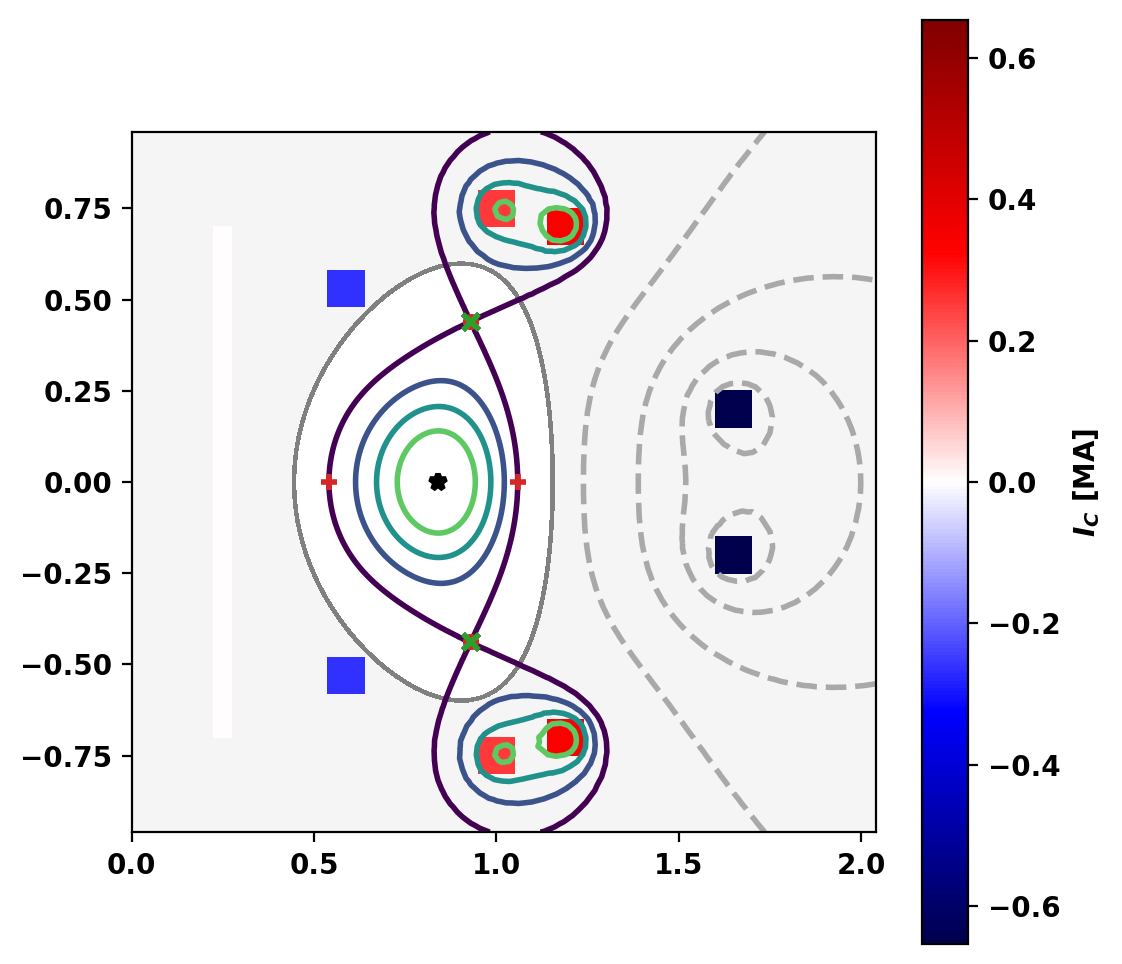

In [13]:
mygs.print_info()
# Plot first case surfaces
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_scale=1.E-6,coil_clabel=r'$I_C$ [MA]',coil_symmap=True,limiter_color=None)
mygs.plot_psi(fig,ax,plasma_nlevels=5,vacuum_nlevels=5)
mygs.plot_constraints(fig, ax)
# Print final coil currents
print()
print("Coil Currents [MA-Turns]:")
coil_currents, _ = mygs.get_coil_currents()
for key in coil_dict:
    i = coil_dict[key]['coil_id']
    print('  {0:10} {1:10.2F}'.format(key+":",coil_currents[i]/1.E6))